Importing relevant packages and modules

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [3]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('../bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

In [5]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [6]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C5_from_env_2']

ncells = len(module_indices)

['C0_from_env_0', 'C1_from_env_1', 'C5_from_env_2']


In [7]:
# percentile is chosen manually to get 315 cells.
gs_masks = grid_score_masks(experiment, percentile=0.547, mode="intersection")
gs_idxs = np.where(gs_masks)[0]

In [8]:
ratemaps = get_smooth_ratemaps(experiment, sigma=1.0)
gc_ratemaps = ratemaps[:,module_indices]

# choose phases from environment 0.
# assume that phases 
phase_magnitudes = np.linalg.norm(np.array(list(map(phase_fn, gc_ratemaps[0]))),axis=-1)
sort_idxs = np.argsort(phase_magnitudes)

In [7]:
def load_model(experiment, random_model=False):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    if not random_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)
random_model = load_model(experiment, random_model=True)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [8]:
"""
agent = experiment.agents[0]
pcs = experiment.pc_ensembles[0]

num_trajectories = 100
len_trajectory = 1000

positions = []
velocities = []
for n in tqdm.trange(num_trajectories):
    agent.reset()
    [agent.step() for i in range(len_trajectory)]
    positions.append(agent.positions)
    velocities.append(agent.velocities[1:])

positions = np.array(positions)
velocities = np.array(velocities)
positions = torch.tensor(positions)
velocities = torch.tensor(velocities)
"""
_ = 2

In [9]:
#dataset = Dataset(experiment.agents, experiment.pc_ensembles, num_samples=1e+6, seq_len=100)
#(v,p0),labels,p,idx = dataset[0]

In [10]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [11]:
def pred_inference(model, inputs, labels, positions, indices, trajectory_slice=None):
    trajectory_slice = slice(0,positions.shape[1]) if trajectory_slice is None else trajectory_slice
    position_slice = slice(trajectory_slice.start,trajectory_slice.stop+1)
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions[:,trajectory_slice], 
                                      positions[:,position_slice], indices, model.place_cell_ensembles)
    return pred_error.item()

In [12]:
def prune_model(model, dataloader, module_indices, gs_idxs, nsteps=40, trajectory_slice=slice(19,20)):
    pe_true = []
    pe_random = []
    pe_gcs = []
    pe_random_torus = []
    pe_sorted_torus = []
    pe_random_inverse_torus = []
    pe_random_model = []
    ncells2prune = int(round(len(module_indices)  / nsteps))

    # bag/hat to keep continuous pruning idxs in
    random_idxs2prune = np.array([])
    random_torus_idxs2prune = np.array([])
    random_inverse_torus_idxs2prune = np.array([])
    random_gcs_idxs2prune = np.array([])

    i = 0
    for inputs, labels, positions, indices in dataloader:
        i+=1

        # true
        model.prune_mask = []
        pe_true.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random
        remaining = list(set(range(model.Ng)) - set(random_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune, replace=False)
        random_idxs2prune = np.append(random_idxs2prune, tmp).astype(int)
        model.prune_mask = random_idxs2prune
        pe_random.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random gcs
        remaining = list(set(gs_idxs) - set(random_gcs_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
        random_gcs_idxs2prune = np.append(random_gcs_idxs2prune, tmp).astype(int)
        model.prune_mask = random_gcs_idxs2prune
        pe_gcs.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random torus
        remaining = list(set(module_indices) - set(random_torus_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
        random_torus_idxs2prune = np.append(random_torus_idxs2prune, tmp).astype(int)
        model.prune_mask = random_torus_idxs2prune
        pe_random_torus.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # env0 radius-phase selected torus
        model.prune_mask = module_indices[sort_idxs][:ncells2prune*i]
        pe_sorted_torus.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random inverse torus
        inverse_torus_cells = set(range(model.Ng)) - set(module_indices)
        remaining = list(inverse_torus_cells - set(random_inverse_torus_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune, replace=False)
        random_inverse_torus_idxs2prune = np.append(random_inverse_torus_idxs2prune, tmp).astype(int)
        model.prune_mask = random_inverse_torus_idxs2prune
        pe_random_inverse_torus.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random model
        pe_random_model.append(pred_inference(random_model, inputs, labels, positions, indices, trajectory_slice))
        
        if i == nsteps:
            break
            
    return pe_true, pe_random, pe_gcs, pe_random_torus, pe_sorted_torus, pe_random_inverse_torus, pe_random_model

In [13]:
def prune_stats(nstats, *args, **kwargs):
    stats = []
    for j in tqdm.trange(nstats):
        stats.append(np.array(prune_model(*args, **kwargs)))
    return np.array(stats) # shape: (nstats x 6 x nsteps)

In [12]:
nsteps = 60
nstats = 30
load_stats = True

if load_stats:
    with open(experiment.paths['experiment'] / "pruning_errors.pkl", "rb") as f:
        pruning_errors = pickle.load(f)
else:
    pruning_errors = prune_stats(nstats, model, dataloader, module_indices, gs_idxs, nsteps=nsteps)
    # save pruning errors statistics - since it takes so long to compute it can be loaded instead
    with open(experiment.paths['experiment'] / "pruning_errors.pkl", "wb") as f:
        pickle.dump(pruning_errors, f)

In [18]:
panesize = set_size(width=345, mode='tall')
panesize

figsize=(panesize[0],panesize[1]*2/6)
figsize=np.array(figsize)

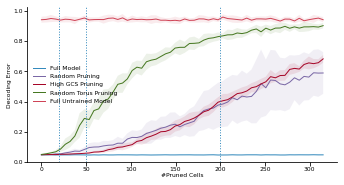

In [22]:
fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.linspace(0, ncells, nsteps)
labels = ['Full Model', 'Random Pruning', 'High GCS Pruning', 'Random Torus Pruning', 
           'Sorted Torus Pruning', 'Random Inverse Torus Pruning', 'Full Untrained Model']

mean_error = np.mean(pruning_errors,axis=0)
std_error = np.std(pruning_errors,axis=0)
median_error = np.median(pruning_errors,axis=0)
mad_error = mad(pruning_errors,axis=0)
for i in [0,1,2,3,4,5,6]: # set order to change color according to color-cycler
    if i in [4,5]:
        continue
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

ax.legend()
ax.set_xlabel('#Pruned Cells')
ax.set_ylabel('Decoding Error')

ax.axvline(20, ls=':')
ax.axvline(50, ls=':')
ax.axvline(200, ls=':')

fig.savefig("/home/vemundss/Desktop/prune")
fig.savefig(experiment.paths['experiment'] / f'plots/pruning')


### Investigate pruning distribution

/tmp/ipykernel_340357/2549402989.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


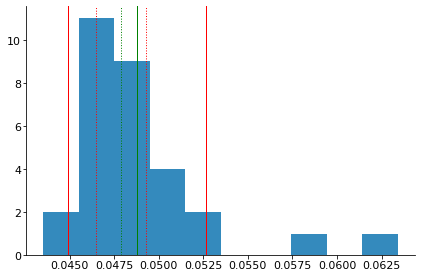

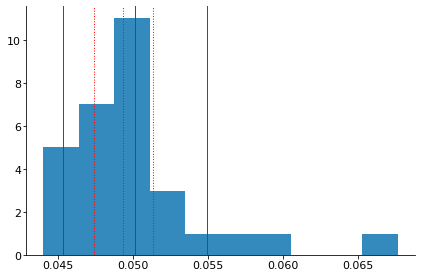

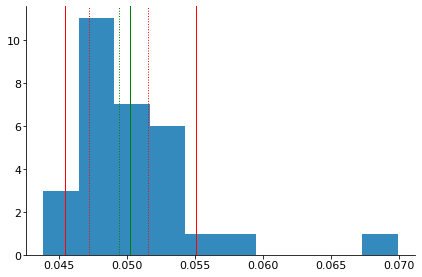

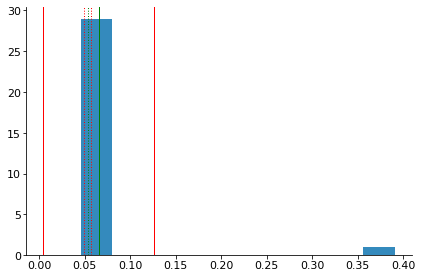

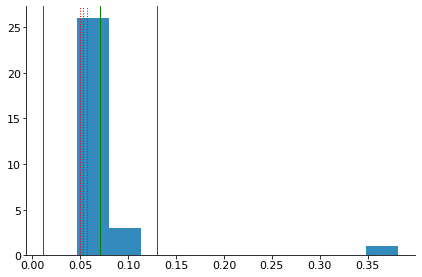

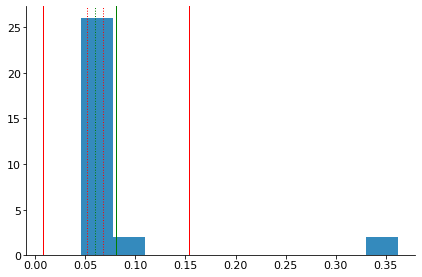

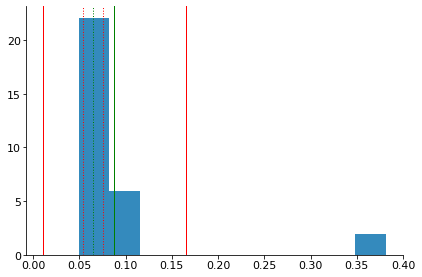

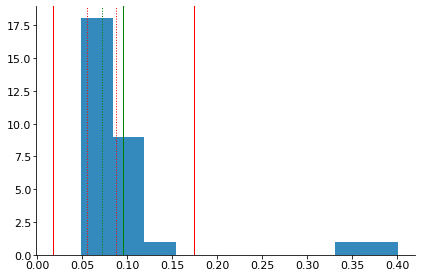

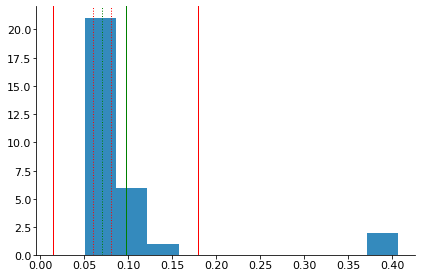

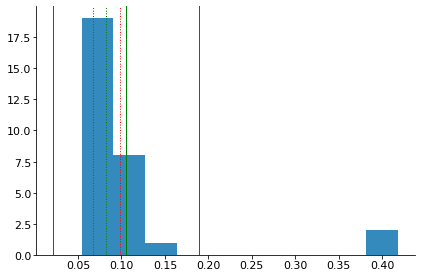

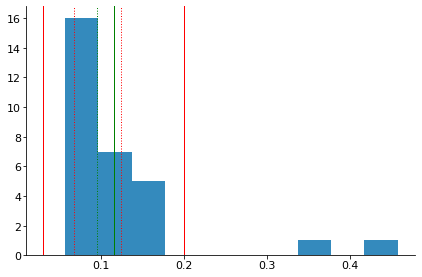

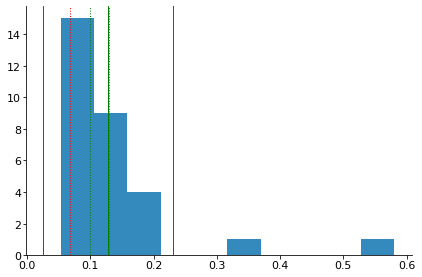

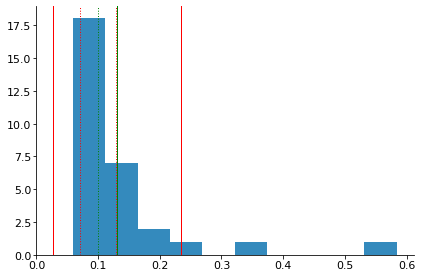

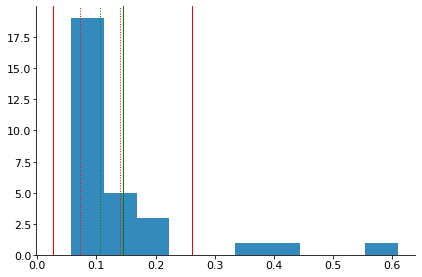

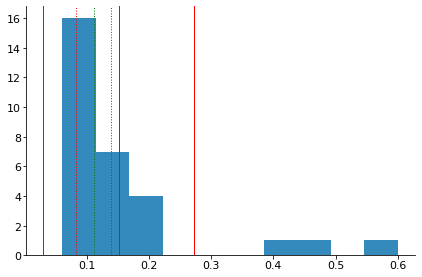

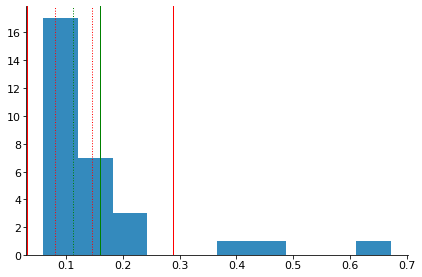

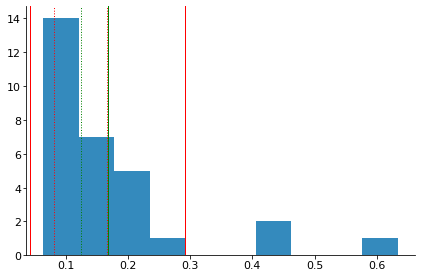

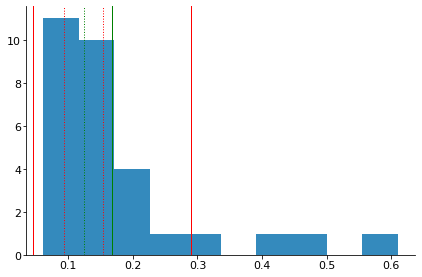

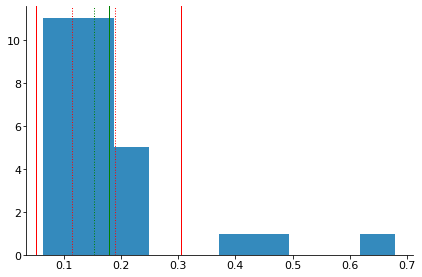

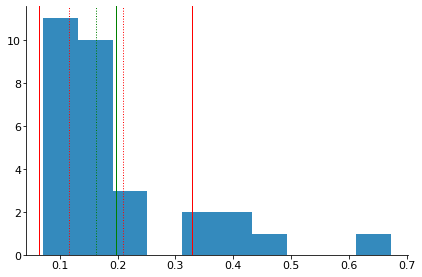

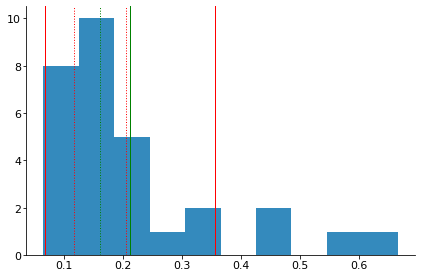

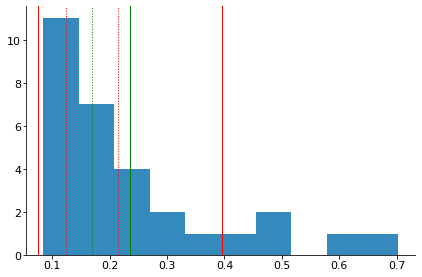

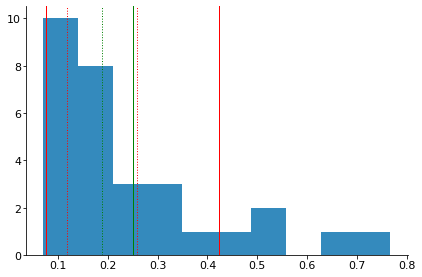

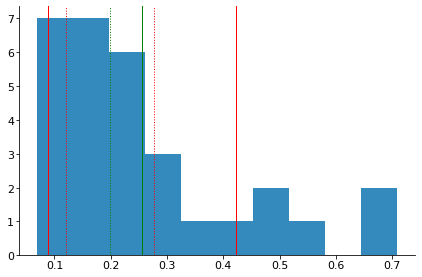

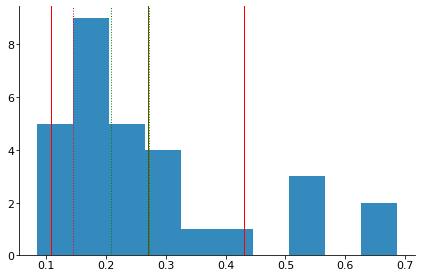

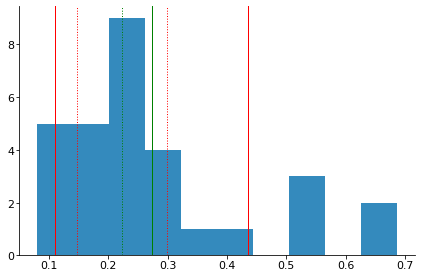

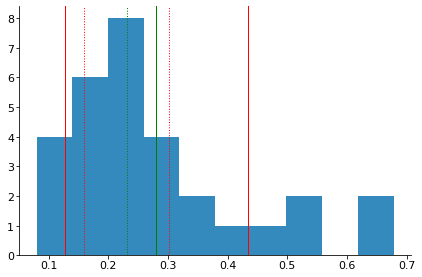

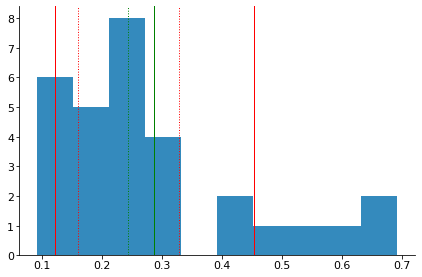

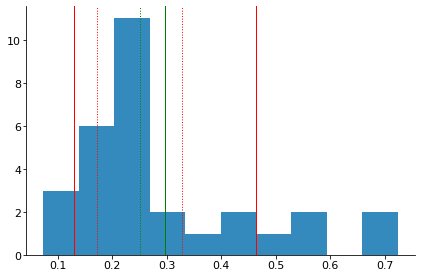

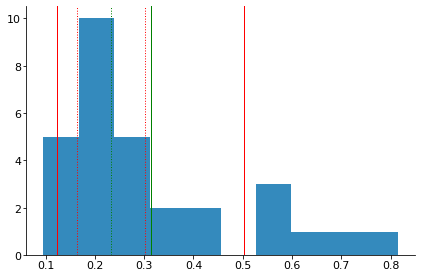

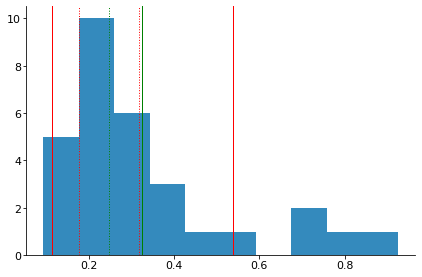

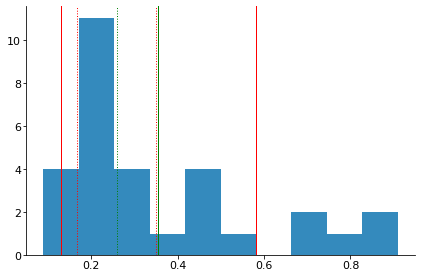

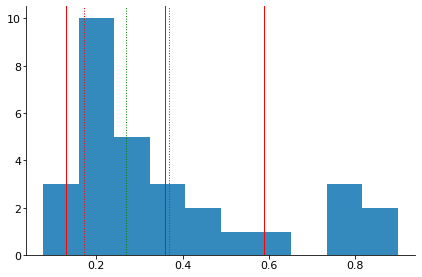

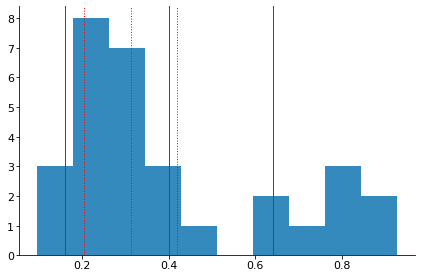

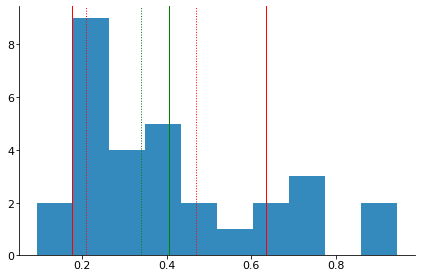

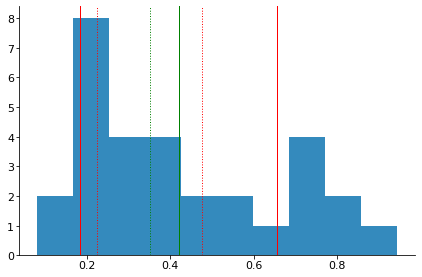

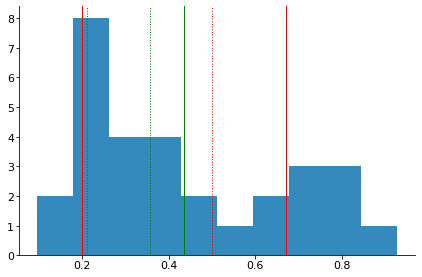

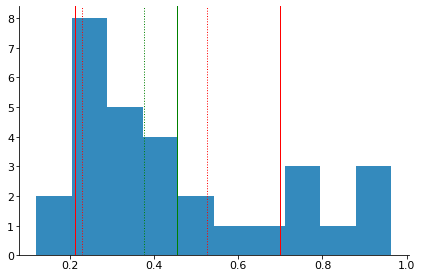

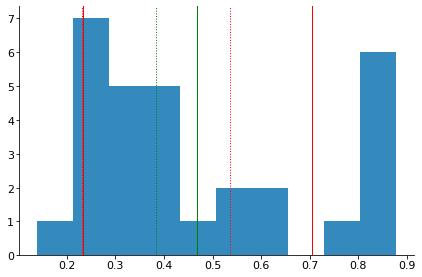

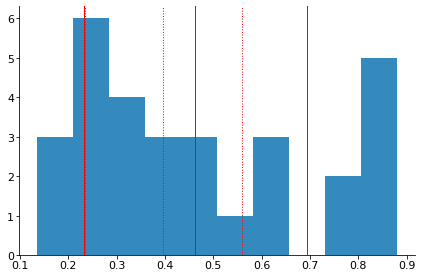

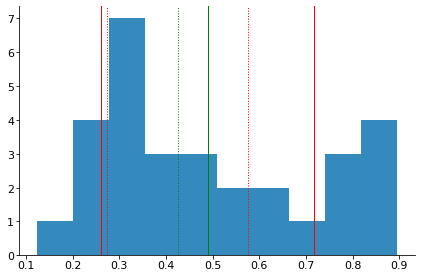

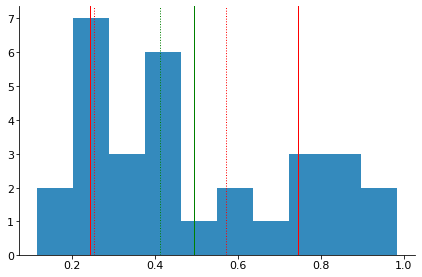

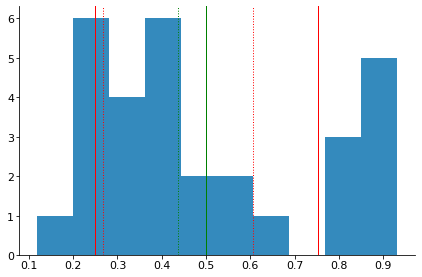

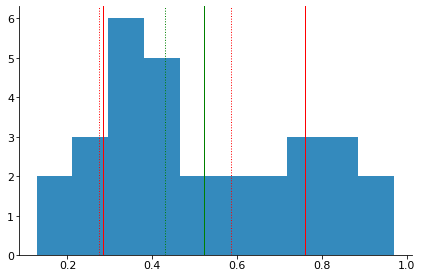

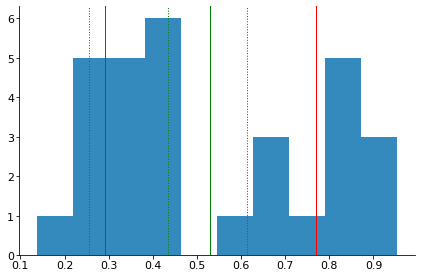

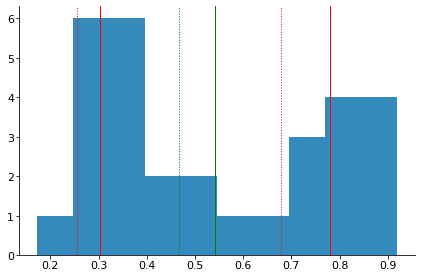

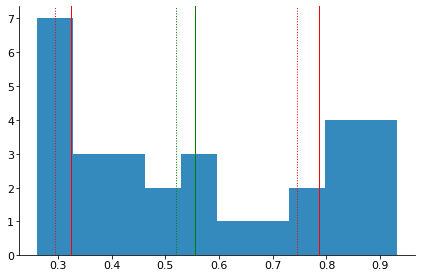

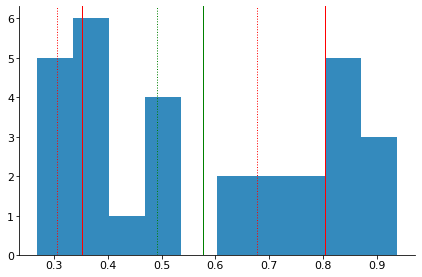

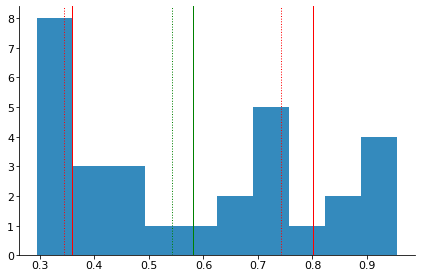

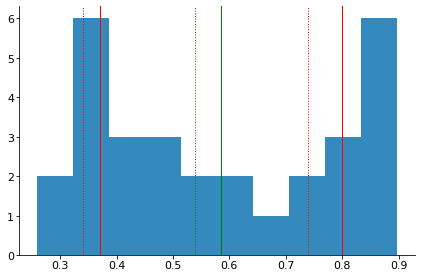

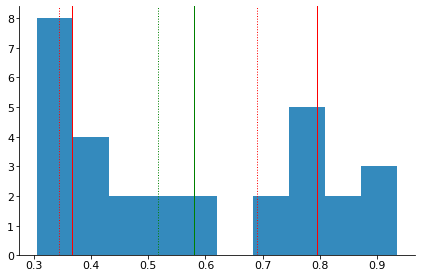

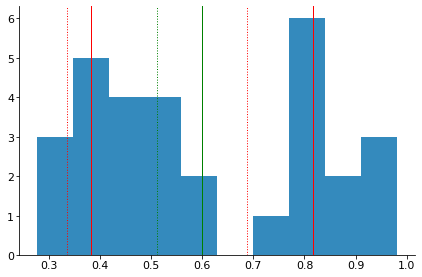

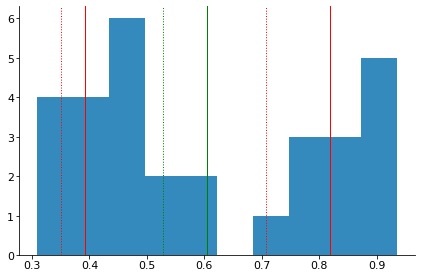

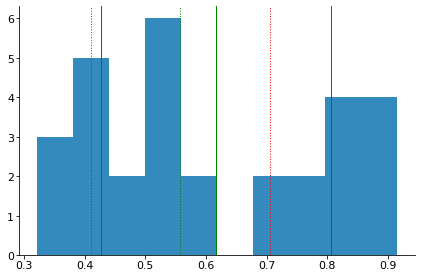

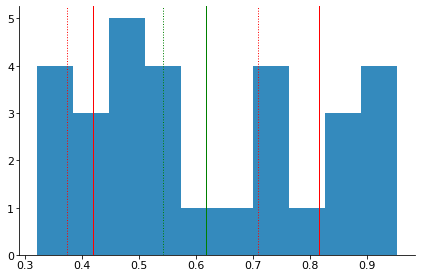

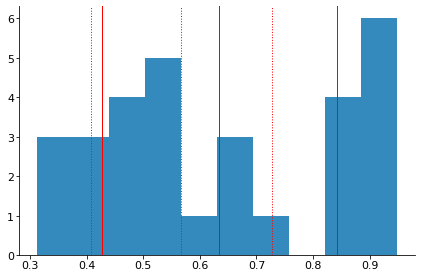

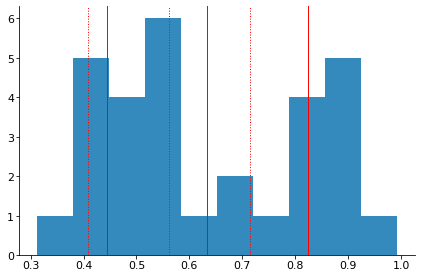

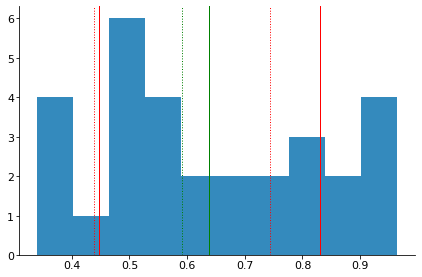

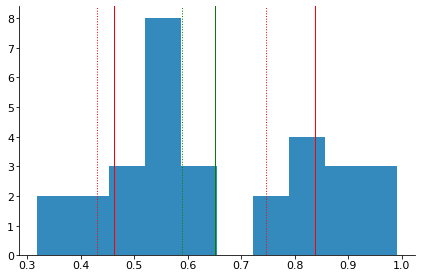

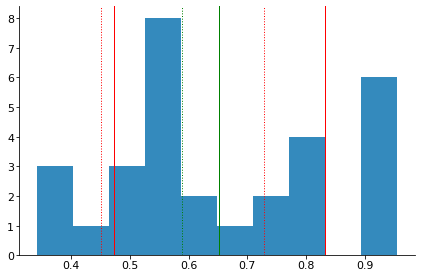

In [16]:
prune_type_id = 1

for i in range(pruning_errors.shape[-1]):
    fig,ax = plt.subplots()
    ax.hist(pruning_errors[:,prune_type_id,i])
    m = np.mean(pruning_errors,axis=0)[prune_type_id,i]
    s = np.std(pruning_errors,axis=0)[prune_type_id,i]
    med = np.median(pruning_errors,axis=0)[prune_type_id,i]
    ma = mad(pruning_errors,axis=0)[prune_type_id,i]
    ax.axvline(m, color='green')
    ax.axvline(m + s, color='red')
    ax.axvline(m - s, color='red')
    
    ax.axvline(med, ls=':', color='green')
    ax.axvline(med + ma, ls=':', color='red')
    ax.axvline(med - ma, ls=':', color='red')
    #ax.set_title(np.mean())

In [17]:
np.min(pruning_errors,axis=0)[1], np.max(pruning_errors,axis=0)[1]

(array([0.0435354 , 0.04403581, 0.04382247, 0.04591884, 0.04640178,
        0.04604377, 0.04941157, 0.04848511, 0.0505147 , 0.05406559,
        0.05660472, 0.05276303, 0.05895361, 0.05771115, 0.05990393,
        0.05925426, 0.06378539, 0.06172954, 0.06342492, 0.07121454,
        0.06548636, 0.08492555, 0.06992704, 0.06853162, 0.08486575,
        0.07956335, 0.0795997 , 0.09104186, 0.0737023 , 0.09558222,
        0.09370572, 0.08896746, 0.07730978, 0.09514828, 0.09305947,
        0.0798049 , 0.09574685, 0.12048686, 0.1377503 , 0.13469546,
        0.12325497, 0.11488078, 0.11771356, 0.12709942, 0.13704731,
        0.17183575, 0.26064825, 0.2674903 , 0.29412735, 0.25837317,
        0.30496591, 0.27607548, 0.30823696, 0.32090881, 0.32009766,
        0.31195828, 0.31158793, 0.33927959, 0.31756437, 0.34148133]),
 array([0.06340877, 0.06764218, 0.06988674, 0.39064389, 0.38132396,
        0.36201882, 0.38158798, 0.40069947, 0.40660468, 0.41816989,
        0.45777467, 0.58002776, 0.58372313, 0.

In [18]:
x_ticks = np.linspace(0, ncells, len(pe_true))
plt.plot(x_ticks, pe_true, label='Full Model')
plt.plot(x_ticks, pe_random, label='Random Pruning')
plt.plot(x_ticks, pe_gcs, label='High GCS Pruning')
plt.plot(x_ticks, pe_random_torus, label='Random Torus Pruning')
#plt.plot(x_ticks, pe_sorted_torus, label='Sorted Torus Pruning')
plt.plot(x_ticks, pe_random_inverse_torus, label='Random Inverse Torus Pruning')
plt.legend()
plt.xlabel('#Pruned Cells')
plt.ylabel('Decoding Error')

plt.savefig("/home/vemundss/Desktop/prune")
plt.savefig(experiment.paths['experiment'] / f'plots/pruning')

NameError: name 'pe_true' is not defined

In [ ]:
# NEXT
# -- DONE -- prune with high GCS
# -- DONE -- prune toroid cells sorted on phase - physics phase transtition?
# legg til error shadings på grafene.
# include adverserial attack?
# -- DONE -- prune inverse of toroid cells. path integration remain? ratemaps still grids? toroid still there?
# select phases based on e.g. right side of box.

# Include random initialised network without pruning to show baseline decoding error